# CALTECH CONTROL PACKAGE

This notebook introduces core elements of the CalTech control package and provides various examples of using the with Tellurium.

# Preliminaries

In [1]:
try:
    import controlSBML as ctl
except:
    !pip install -q controlSBML
    import controlSBML as ctl

import control
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

## Antimony Models

### Linear Model

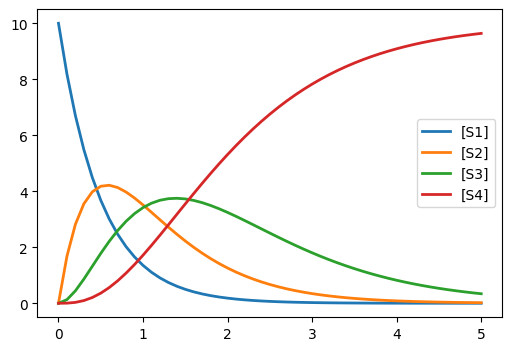

In [2]:
LINEAR_MDL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> S4; k3*S3

k1 = 2
k2 = 1.5
k3 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
LINEAR_RR = te.loada(LINEAR_MDL)
LINEAR_DATA = LINEAR_RR.simulate()
LINEAR_RR.plot(LINEAR_DATA)
LINEAR_STATE_NAMES = ["S1", "S2", "S3", "S4"]
LINEAR_PARAM_DCT = {"input_names": LINEAR_STATE_NAMES, "output_names": LINEAR_STATE_NAMES}

**System Equations**

$
\begin{eqnarray}
\dot{S}_1 & =&  -& k_1 S_1 & +&  0 S_2 &+& 0 S_3 \\
\dot{S}_2 &=& + & k_1 S_1  &-& k_2 S_2 &+& 0S_3 \\
\dot{S}_3 &=& +& 0S_1 &+& k_2 S_2 &-& k_3 S_3 \\
\dot{S}_4 &=& +& 0S_1 &+& 0 S_2 &+& k_3 S_3
\end{eqnarray}
$

### Nonlinear Model

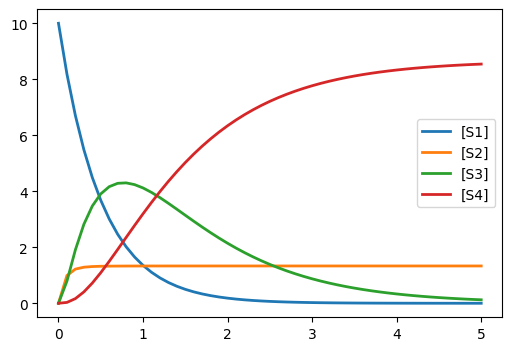

In [3]:
NONLINEAR_MDL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2*S1
S3 -> S4; k3*S3

k1 = 2
k2 = 1.5
k3 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
NONLINEAR_RR = te.loada(NONLINEAR_MDL)
NONLINEAR_DATA = NONLINEAR_RR.simulate()
NONLINEAR_RR.plot(NONLINEAR_DATA)

# Helpers

In [24]:
TEST_MODEL = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""

In [25]:
def plotModel(model=TEST_MODEL, parameter_dct=None, title="", is_plot=True):
    """
    Plots the simulation with the specified parameter values.
    
    Parameters
    ----------
    model: str
    parameter_dct: dict
        key: parameter name
        value: parameter value
    is_plot: bool
    
    Returns
    -------
    NamedArray
    """
    if parameter_dct is None:
        parameter_dct = {}
    rr = te.loada(model)
    for name, value in parameter_dct.items():
        rr[name] = value
    simulation_results = rr.simulate()
    if is_plot:
        rr.plot(simulation_results, title=title)
    return simulation_results
    
# TESTS
results = plotModel(is_plot=False)
assert("NamedArray" in str(type(results)))
print("OK")

OK


In [4]:
def plotSys(sys, param_dct, is_plot=True):
    """
    Constructs a plot for a system.
    
    Parameters
    ----------
    sys: control.NonlinearIOSystem
    param_dct: dict
        key: "input_names", value: list-str
        key: "output_names", value: list-str
    """
    # Simulate the system
    X0 = [10, 0, 0, 0]               # Initial conditions for species concentrations
    T = np.linspace(0, 5, 101)   # Simulation 70 years of time

    # Simulate the system
    t, y = control.input_output_response(sys, T, 0, X0, params=param_dct)

    output_names = param_dct["output_names"]
    # Plot the response
    plt.figure(1)
    for idx in range(len(output_names)):
        plt.plot(t, y[idx])
    plt.legend(output_names)
    if not is_plot:
        plt.close()
    else:
        plt.show(block=False)
    
# Tests
ctlsb = ctl.ControlSBML(LINEAR_MDL)
sys = ctlsb.makeNonlinearIOSystem("linear_mdl")
plotSys(sys, LINEAR_PARAM_DCT, is_plot=False)
print("OK!")

OK!


# The ``control`` Package

Provides a wide range of capabilities for defining, analyzing, and designing systems.
This lecture focuses on the following:
* Defining a system using the ``NonlinearIOSystem`` class.
* Simulating a system using ``input_output_response``


## Defining a System

A system is defined by a combination of a state transition function and an output function.
* The state transition function returns the time derivative of each state variable
* The output function returns the value of all outputs at the current state.

An example.

### Predator-Prey Example

In [5]:
def updfcnPP(time, x_vec, u_vec, param_dct):
    """
    Calculates the derivative of populations of hare (H) and lynx (L).
    
    Parameters
    ----------
    time: float (time of state)
    x_vec: array-float (H, L)
    u_vec: float (change to hare population)
    param_dct: dictionary of other parameters
    
    Returns
    -------
    list-float (dH, dL)
    """
    # Parameter setup
    a = param_dct.get('a', 3.2)  # Get value assigned to 'a' or its default
    b = param_dct.get('b', 0.6)
    c = param_dct.get('c', 50.)
    d = param_dct.get('d', 0.56)
    k = param_dct.get('k', 125)
    r = param_dct.get('r', 1.6)

    # Map the states into local variable names
    H = x_vec[0]
    L = x_vec[1]

    # Compute the control action (only allow addition of food)
    u_0 = u_vec if u_vec > 0 else 0

    # Compute the discrete updates
    dH = (r + u_0) * H * (1 - H/k) - (a * H * L)/(c + H)
    dL = b * (a * H *  L)/(c + H) - d * L

    return [dH, dL]

# Tests
result = updfcnPP(0, [10, 2], 1, {})
assert(len(result) == 2)
print("OK!")

OK!


In [6]:
def outfcnPP(time, x_vec, u_vec, param_dct):
    return x_vec

# Tests
assert(len(outfcnPP(0, [0, 1], None, None)) == 2)

In [7]:
predprey = control.NonlinearIOSystem(
    updfcnPP, outfcnPP, inputs=('u'), outputs=('H', 'L'),
    states=('H', 'L'), name='predprey')

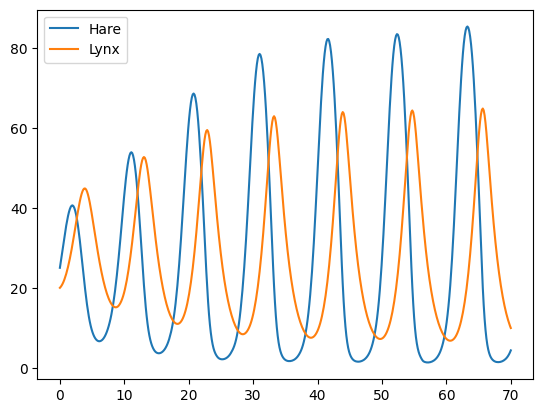

In [8]:
# Simulate the system
X0 = [25, 20]                 # Initial H, L
T = np.linspace(0, 70, 500)   # Simulation 70 years of time

# Simulate the system
t, y = control.input_output_response(predprey, T, 0, X0)

# Plot the response
plt.figure(1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['Hare', 'Lynx'])
plt.show(block=False)

# Creating ``NonlinearIOSystem`` Objects for ``LINEAR_MDL``

## Using the system equations

**System Equations**

$
\begin{eqnarray}
\dot{S}_1 & =&  -& k_1 S_1 & +&  0 S_2 &+& 0 S_3 \\
\dot{S}_2 &=& + & k_1 S_1  &-& k_2 S_2 &+& 0S_3 \\
\dot{S}_3 &=& +& 0S_1 &+& k_2 S_2 &-& k_3 S_3 \\
\dot{S}_4 &=& +& 0S_1 &+& 0 S_2 &+& k_3 S_3
\end{eqnarray}
$

In [9]:
def updfcnLinear(_, x_vec, u_vec, param_dct):
    """
    Calculates the derivative of populations of hare (H) and lynx (L).
    
    Parameters
    ----------
    x_vec: array-float (S1, S2, S3, S4)
    u_vec: float
    param_dct: dictionary of other parameters (k1, k2, k3)
    
    Returns
    -------
    list-float (dS1, dS2, dS3, dS4)
    """
    # Initializations
    k1 = param_dct.get("k1", 2.0)
    k2 = param_dct.get("k2", 1.5)
    k3 = param_dct.get("k3", 1.0)
    s1 = x_vec[0]
    s2 = x_vec[1]
    s3 = x_vec[2]
    s4 = x_vec[3]
    #
    ds1 = -k1*s1
    ds2 = k1*s1 - k2*s2
    ds3 = k2*s2 - k3*s3
    ds4 = k3*s3
    #
    return [ds1, ds2, ds3, ds4]

# Tests
result = updfcnLinear(None, [10, 0, 0, 0], None, {})
assert(len(result) == 4)
assert(np.isclose(result[3], 0))
print("OK!")

OK!


In [10]:
def outfcnLinear(_, x_vec, __, ___):
    """
    Returns
    -------
    float: S1, S2, S3, S4
    """
    return x_vec

# Tests
assert(len(outfcnPP(None, [1, 1, 1, 1], None, None)) == 4)
print("OK!")

OK!


In [11]:
state_names = ["S1", "S2", "S3", "S4"]
output_names = state_names
linear_sys = control.NonlinearIOSystem(
    updfcnLinear, outfcnLinear, inputs=('u'), outputs=output_names,
    states=state_names, name='linear_sys')

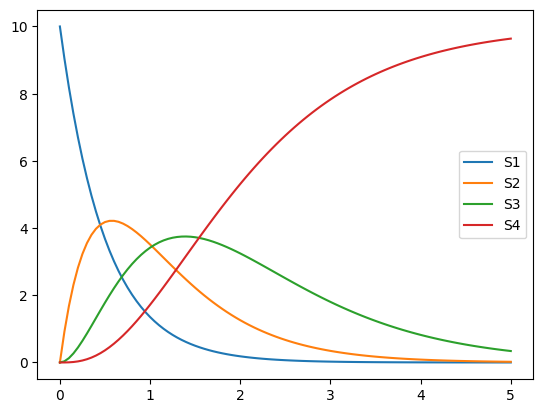

In [18]:
# Simulate the system
X0 = [10, 0, 0, 0]               # Initial conditions for species concentrations
T = np.linspace(0, 5, 101)   # Simulation 70 years of time

# Simulate the system
t, y = control.input_output_response(linear_sys, T, 0, X0)

# Plot the response
plt.figure(1)
for idx in range(len(output_names)):
    plt.plot(t, y[idx])
plt.legend(output_names)
plt.show(block=False)

In [19]:
output_names

['S1', 'S2', 'S3', 'S4']

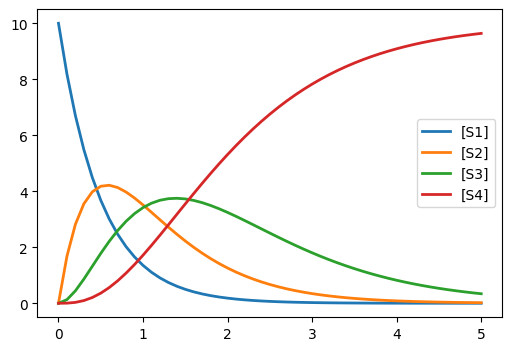

In [20]:
# Compare with the Tellurium simulation
LINEAR_RR.plot(LINEAR_DATA)

# Exercise: Create ``NonlinearIOSystem`` and simulate it for ``NONLINEAR_MDL``

Implement
* ``updfcnNonlinear``
* ``outfcNonlinear``
* Create ``nonlinear_sys``, a ``NonlinearIOSystem``
* Simulate ``nonlinear_sys`` and compare with Tellurium simulation

# Writing ``updfcn`` and ``outfcn`` in general for an SBML model

We want to create ``NonlinearIOSystem`` objects for SBML models.
This could be done by manually examining the models and constructing a set of equations, but doing so
is time consuming and error prone.
Below, we develop a general method.

In [21]:
# We can get the derivative of a species concentration at the current simulation time
#timepoint = 0.5  # Time at which we want the derivative
#LINEAR_RR.reset()  # Start at time 0
#_ = LINEAR_RR.simulate(0, timepoint)  # Simulate to the timepoint
# Set values of state
LINEAR_RR["S1"] = 10
LINEAR_RR["S2"] = 0
LINEAR_RR["S3"] = 0
LINEAR_RR["S4"] = 0
# Get the derivatives
ds1 = LINEAR_RR["S1'"]
ds2 = LINEAR_RR["S2'"]
ds3 = LINEAR_RR["S3'"]
ds4 = LINEAR_RR["S4'"]
[ds1, ds2, ds3, ds4]

[-20.0, 20.0, 0.0, 0.0]

In [23]:
def updfcnSBML(timepoint, x_vec, __, param_dct):
    """
    Calculates the derivative of populations of hare (H) and lynx (L).
    
    Parameters
    ----------
    x_vec: array-float (S1, S2, S3, S4)
    param_dct: dict
        "roadrunner": ExtendedRoadrunner
        "state_names": list of states
    
    Returns
    -------
    list-float (same size as state)
    """
    state_names = param_dct["state_names"]
    roadrunner = param_dct["roadrunner"]
    roadrunner.reset()
    _ = roadrunner.simulate(0, timepoint, 2)
    #
    for idx, state in enumerate(states):
        roadrunner[state] = x_vec[idx]
    #
    dstates = []
    for state_name in state_names:
        name = "%s'" % state_name
        dvalue = roadrunner[name]
        dstates.append(dvalue)
    #
    return dstates
        
        
        
    # Initializations
    k1 = param_dct.get("k1", 2.0)
    k2 = param_dct.get("k2", 1.5)
    k3 = param_dct.get("k3", 1.0)
    s1 = x_vec[0]
    s2 = x_vec[1]
    s3 = x_vec[2]
    s4 = x_vec[3]
    #
    ds1 = -k1*s1
    ds2 = k1*s1 - k2*s2
    ds3 = k2*s2 - k3*s3
    ds4 = k3*s3
    #
    return [ds1, ds2, ds3, ds4]

# Tests
param_dct = {"roadrunner": LINEAR_RR, "state_names": ["S1", "S2", "S3", "S4"]}
result = updfcnSBML(1, [10, 0, 0, 0], None, param_dct)
assert(len(result) == 4)
print("OK!")

NameError: name 'states' is not defined

In [ ]:
def outfcnSBML(_, x_vec, __, param_dct):
    """
    Calculates the derivative of populations of hare (H) and lynx (L).
    
    Parameters
    ----------
    x_vec: array-float (S1, S2, S3, S4)
    param_dct: dict
        "state_names" list-str
        "output_names": list-str (subset of states)
    
    Returns
    -------
    list-float (same size as state)
    return x_vec
    """
    state_names = param_dct["state_names"]
    output_names = param_dct["output_names"]
    #
    output_vals = []
    for idx, state_name in enumerate(state_names):
        if state_name in output_names:
            output_vals.append(x_vec[idx])
    #
    return output_vals

# Tests
param_dct = {"roadrunner": LINEAR_RR, "state_names": ["S1", "S2", "S3", "S4"], "output_names": ["S2", "S3"]}
output_vals = outfcnSBML(None, [1, 1, 1, 1], None, param_dct)
assert(len(output_vals) == 2)
print("OK!")

In [ ]:
output_names = ["S1", "S2", "S3", "S4"]
param_dct = {"roadrunner": LINEAR_RR, "state_names": ["S1", "S2", "S3", "S4"], "output_names": output_names}
linear_sbml_sys = control.NonlinearIOSystem(
    updfcnSBML, outfcnSBML, inputs=('u'), outputs=param_dct["output_names"],
    states=param_dct["state_names"], name='linear_sbml_sys')

In [ ]:
# Simulate the system
X0 = [10, 0, 0, 0]               # Initial conditions for species concentrations
T = np.linspace(0, 5, 101)   # Simulation 70 years of time

# Simulate the system
t, y = control.input_output_response(linear_sbml_sys, T, 0, X0, params=param_dct)

output_names = param_dct["output_names"]
# Plot the response
plt.figure(1)
for idx in range(len(output_names)):
    plt.plot(t, y[idx])
plt.legend(output_names)
plt.show(block=False)

# Exercise: Using the general functions to create a ``NonlinearIOSystem`` object for ``NONLINEAR_MDL``

# Using ``controlSBML`` With ``control``

In [ ]:
ctlsb = ctl.ControlSBML(LINEAR_MDL)
sys = ctlsb.makeNonlinearIOSystem("linear_mdl")
plotSys(sys, LINEAR_PARAM_DCT)